# Analyse Kath.ch
Let's get some inside from kath.ch

In [1]:
import pandas as pd
from matplotlib import pyplot
import statsmodels.api as sm
import json
import glob
from pathlib import Path
#import plotly
#pd.options.plotting.backend = "plotly"

## Defs

In [2]:
agencies = ['kna', 'sda', 'cic', 'kap']
path_in = Path('../data_cleaned/article/')
red = 'red'
grey = '#adadad'

## Load files

In [3]:
filelist = glob.glob(str(path_in / Path("*.json")))
records = []
for f in filelist:
    with open(f, encoding='utf-8') as json_file:
        records.append(json.load(json_file))

In [4]:
df = pd.DataFrame(records)
df['date'] = pd.to_datetime(df['date'])

# Analyze

## Articles per day
https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621

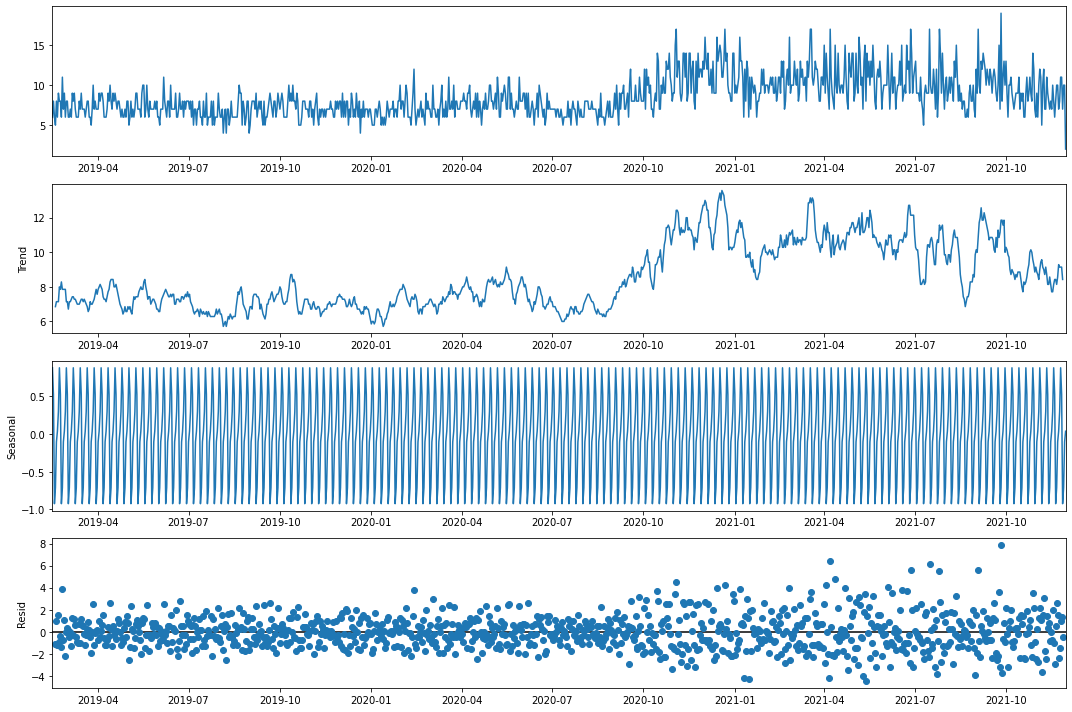

In [5]:
df_data = df.copy()
df_data['_date'] = df_data['date'].dt.date
df_data['_date'] = pd.to_datetime(df_data['_date'])
gr = df_data.groupby('_date').agg({'id': 'count'})#.reset_index()

decomposition = sm.tsa.seasonal_decompose(gr, model = 'additive')
pyplot.rcParams['figure.figsize'] = [15, 10]
fig = decomposition.plot()

<AxesSubplot:xlabel='_date'>

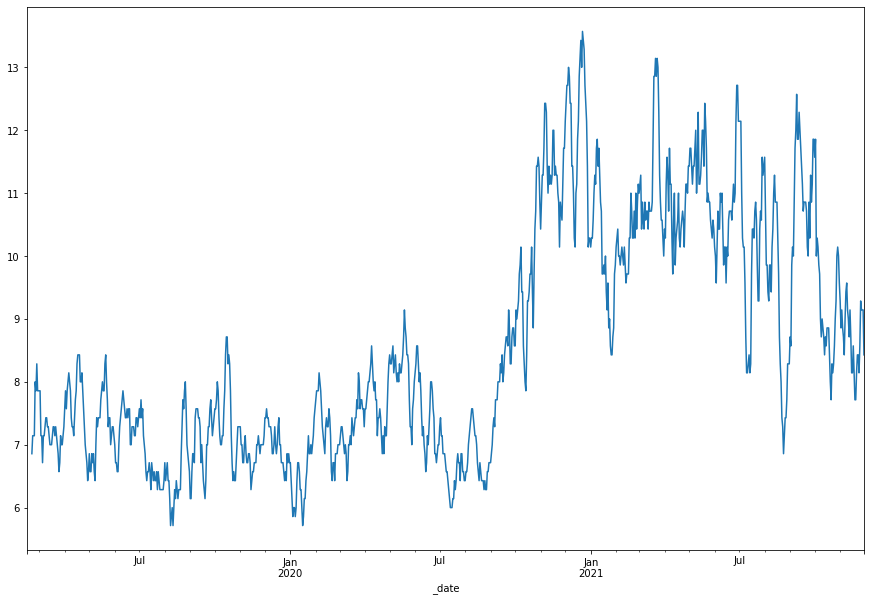

In [6]:
## Rolling avg 7
gr['avg'] = gr['id'].rolling(window=7).mean()
gr['avg'].plot()

## Top Writers
CIC = "Centrum Informationis Catholicum"

In [7]:
# Translate Kürzel
def abb2name(x):
    if x == 'bal': return 'Barbara Ludwig'
    if x == 'gs': return "Georges Scherrer"
    if x == "ms": return "Martin Spilker"
    if x == "rp": return "Regula Pfeifer"
    if x == "uab": return "Ueli Abt"
    if x == "rr": return "Raphael Rauch"
    if x == "bfl": return "Barbara Fleischman"
    if x == "nf": return "Natalie Fritz"
    if x == "mma": return "Monika Marti"
    if x == "bm": return "Beatrice Mock"
    return x

<AxesSubplot:xlabel='author'>

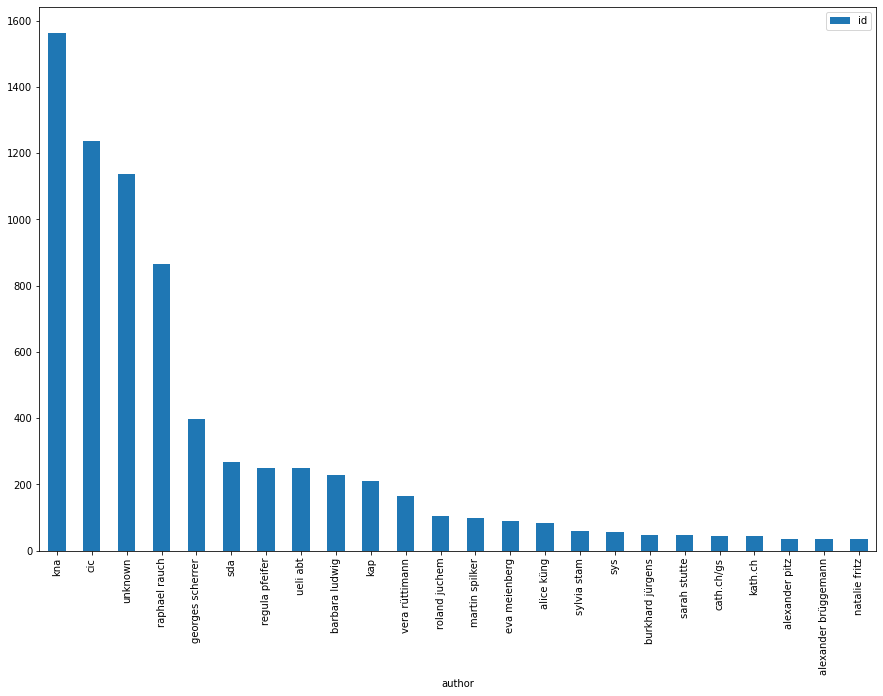

In [8]:
df_data = df.copy()

df_data['author'] = df_data['author'].apply(abb2name)

df_data['author'] = df_data['author'].fillna('unknown')

gr = df_data.groupby(df_data.author.str.lower()).agg({'id': 'count'}).sort_values('id', ascending=False)
gr = gr[gr['id'] >= 30]
gr.plot.bar()

## Writer by time

In [9]:
# Get Top Writers with more than 40 articles
df_data = df.copy()

df_data['author'] = df_data['author'].apply(abb2name)

df_data['author'] = df_data['author'].fillna('unknown')

df_top = df_data.groupby(df_data.author.str.lower()).agg({'id': 'count'}).sort_values('id', ascending=False)
df_top = df_top[df_top['id'] >= 40]
df_top['top'] = True

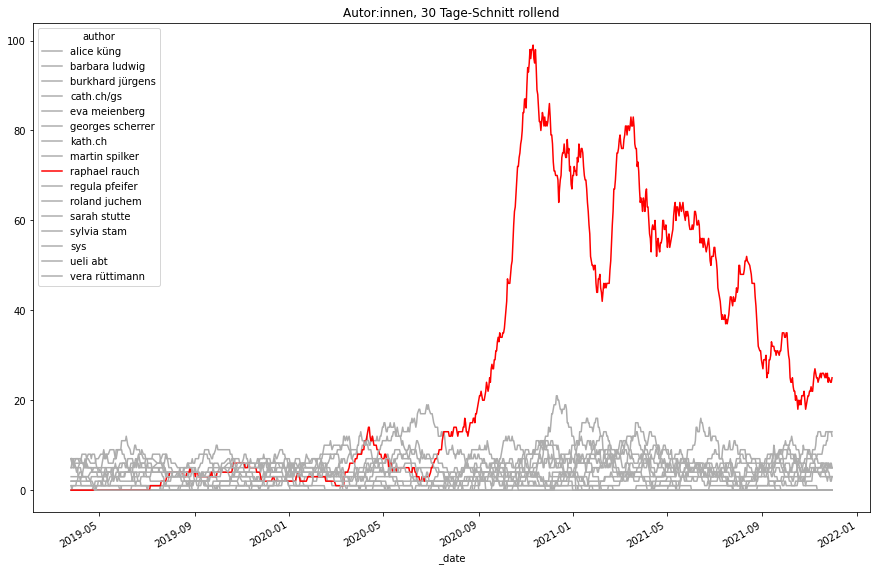

In [10]:
df_data = df.copy()

df_data['author'] = df_data['author'].fillna('unknown')

# Lower Case
df_data['author'] = df_data['author'].str.lower()

# Join
df_data = df_data.merge(df_top, how='left', on='author')
df_data['top'] = df_data['top'].fillna(False)

# Only top authors (writers with more than 40 articles)
df_data = df_data[df_data.top]

# Add Agency
df_data['agency'] = df_data['author'].apply(lambda x: x in agencies)
df_data = df_data[df_data.agency == False]
df_data = df_data[df_data.author != "unknown"]

# Set date
df_data['_date'] = df_data['date'].dt.date
df_data['_date'] = pd.to_datetime(df_data['_date'])
df_data['_month'] = df_data['_date'].apply(lambda x: "%s-%s" % (x.year, x.month))

#df_data = df_data[['_date', 'author', 'title']]

gr = pd.pivot_table(df_data, index='_date', columns='author', values='title', aggfunc='count')
gr = gr.fillna(0)

# Add Rolling AVG
gr = gr.apply(lambda col: col.rolling(30).sum(), axis = 0)

colors = []
for c in gr.columns:
    if c == 'raphael rauch':
        colors.append(red)
    else: colors.append(grey)
    
#gr.plot()
plot = gr.plot(color=colors,  title='Autor:innen, 30 Tage-Schnitt rollend')
plot.get_figure().savefig('../export/autoren.png')

In [11]:
df_data[df_data.date >= '01-01-2021'].groupby('author').agg({'id_x': 'count'})

,id_x
author,
alice küng,56
barbara ludwig,58
burkhard jürgens,6
cath.ch/gs,18
eva meienberg,61
georges scherrer,70
kath.ch,34
raphael rauch,499
regula pfeifer,88


## Alle Artikel Zunahme

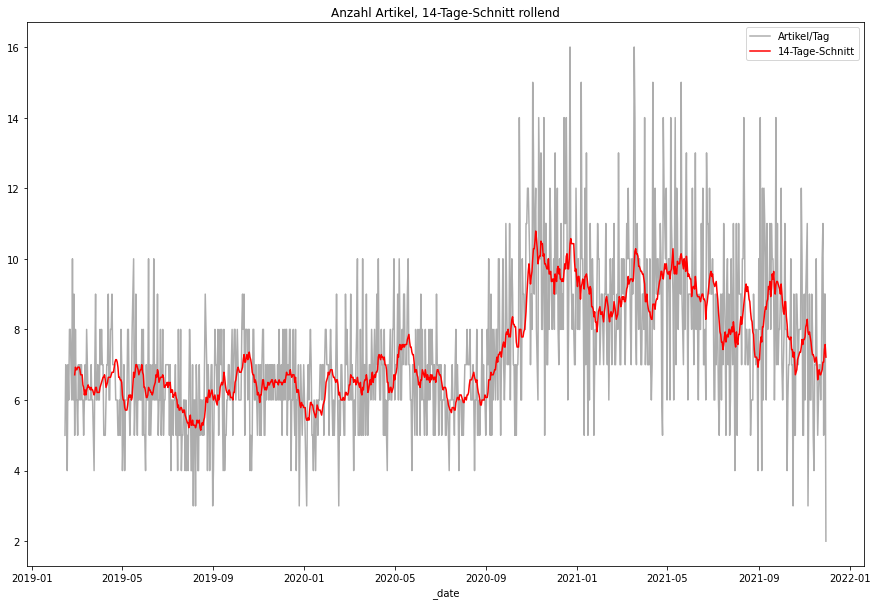

In [12]:
df_data = df.copy()

df_data['_date'] = df_data['date'].dt.date


df_data = df_data.groupby('_date').agg({'author': 'count'})
df_data['14-Tage-Schnitt'] = df_data['author'].rolling(14).mean()
df_data.rename(columns={'author': 'Artikel/Tag'}, inplace=True)


colors = []
for c in df_data.columns:
    if c == '14-Tage-Schnitt':
        colors.append(red)
    else: colors.append(grey)

plot = df_data.plot(color=colors, title='Anzahl Artikel, 14-Tage-Schnitt rollend')
plot.get_figure().savefig('../export/artikelzunahme.png')

In [13]:
df_2020 = df[(df.date >= '01-01-2020') & (df.date <= '31-05-2020')]
df_2021 = df[(df.date >= '01-01-2021') & (df.date <= '31-05-2021')]

print(len(df_2020))
print(len(df_2021))

1117
1605


## Agenturen?

<AxesSubplot:xlabel='_date'>

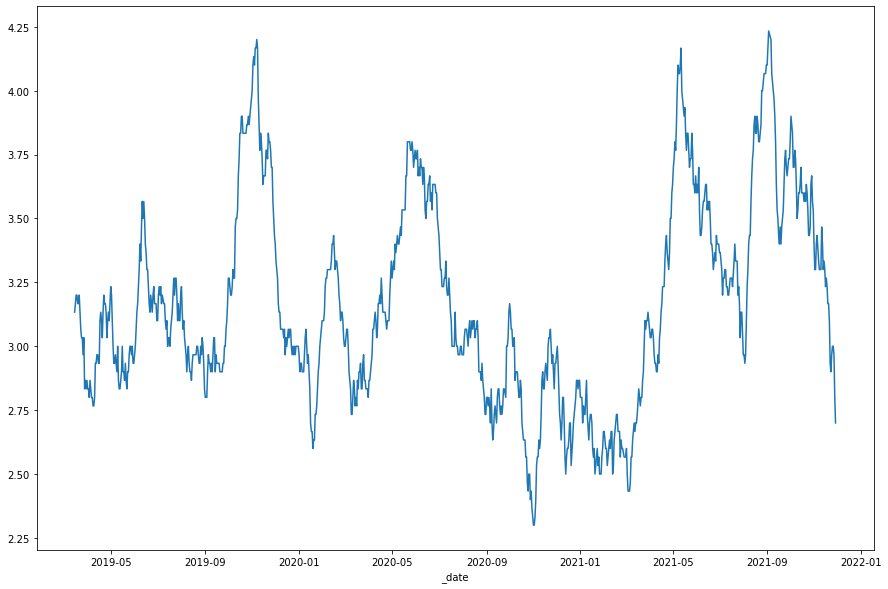

In [14]:
df_data = df[df.author.isin(agencies)].copy()

# Set date
df_data['_date'] = df_data['date'].dt.date

df_data = df_data.groupby('_date').agg({'id': 'count'})
df_data['rolling'] = df_data['id'].rolling(window=30).mean()

df_data['rolling'].plot()

In [15]:
# Count Agenturen 5 Monate

df_data = df[df.author.isin(agencies)].copy()

df_2020 = df[(df.date >= '01-01-2020') & (df.date <= '31-05-2020')]
df_2021 = df[(df.date >= '01-01-2021') & (df.date <= '31-05-2021')]

print(len(df_2020))
print(len(df_2021))

1117
1605


## Kategorie Type

<AxesSubplot:xlabel='_date'>

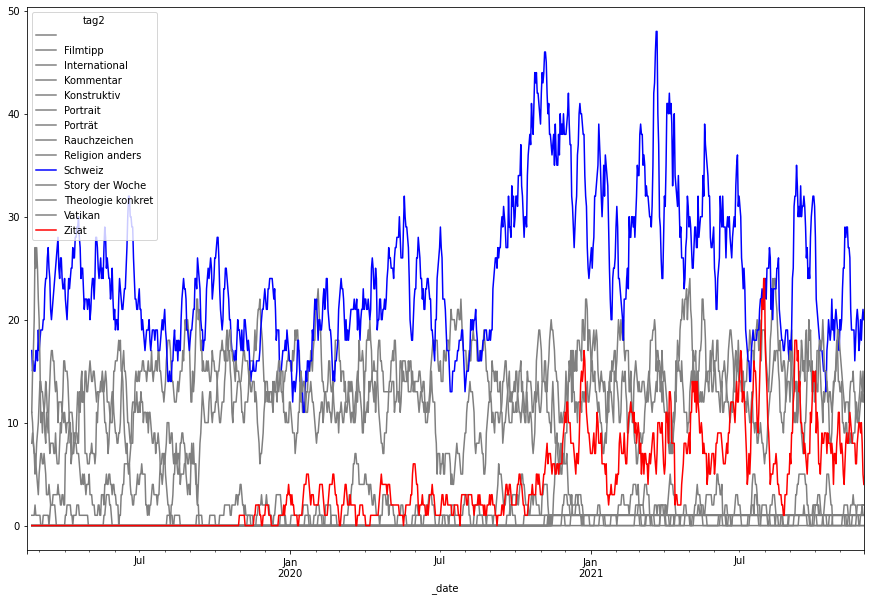

In [16]:
df_data = df.copy()

# Set date
df_data['_date'] = df_data['date'].dt.date
df_data['_date'] = pd.to_datetime(df_data['_date'])


gr = pd.pivot_table(df_data, index='_date', columns='tag2', values='title', aggfunc='count')
gr = gr.fillna(0)

# Add Rolling AVG
gr = gr.apply(lambda col: col.rolling(7).sum(), axis = 0)

colors = []
for c in gr.columns:
    if c == 'Zitat':
        colors.append('red')
    elif c == 'Schweiz':
        colors.append("blue")
    else: colors.append('grey')
    
gr.plot(color=colors)

## Kategorie Vergleich Januar - Mai 2020/2021

In [17]:
df_data = df.copy()

df_data.loc[(df.date >= '01-01-2020') & (df.date <= '31-05-2020'), 'periode'] = 2020
df_data.loc[(df.date >= '01-01-2021') & (df.date <= '31-05-2021'), 'periode'] = 2021

df_data = df_data[df_data.periode.notna()]

df_data = df_data[df_data.tag != ""]

df_data['periode'] = df_data['periode'].astype(int)

df_data = pd.pivot_table(df_data, index='periode', columns='tag', values='id', aggfunc='count')

df_data

tag,Filmtipp,International,Kommentar,Konstruktiv,Porträt,Rauchzeichen,Religion anders,Schweiz,Story der Woche,Theologie konkret,Vatikan,Zitat
periode,,,,,,,,,,,,
2020,NaN,316.0,15.0,NaN,NaN,NaN,NaN,469.0,NaN,NaN,264.0,50.0
2021,21.0,333.0,29.0,20.0,19.0,21.0,23.0,666.0,21.0,22.0,261.0,158.0


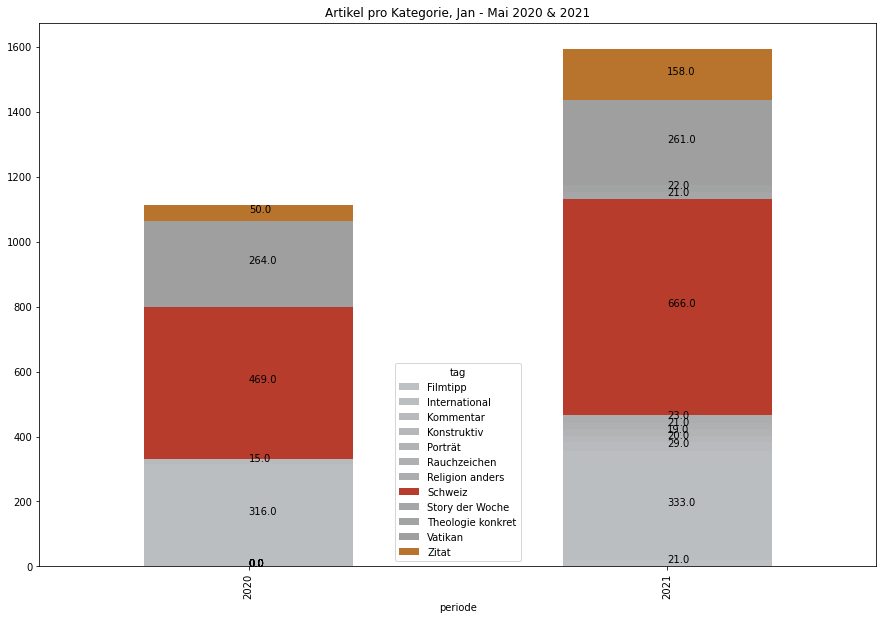

In [18]:
colors = []
r1 = "#b83c2c"
r2 = "#b8742c"
col = ['#00429d', '#2653a5', '#3a64ad', '#4b75b4', '#5b87bc', '#6b99c3', '#7bacca', red, '#9fd0d6', '#b5e2dc', '#d1f3e0', red]
col = ['#bec1c4', '#bbbec0', '#b8babd', '#b5b7b9', '#b2b3b5', '#aeb0b2', '#abadae', r1, '#a5a6a7', '#a2a3a3', '#9f9fa0', r2]
for c in df_data.columns:
    if c == 'Zitat':
        colors.append(red)
    else: colors.append('grey')
        
ax = df_data.plot(kind='bar', stacked=True, color=col, title="Artikel pro Kategorie, Jan - Mai 2020 & 2021")

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_y() + p.get_height() / 2))
    
fig = ax.get_figure()
fig.savefig('../export/tags_barchart.png')

## Kategorie Type by Month

<AxesSubplot:xlabel='_date'>

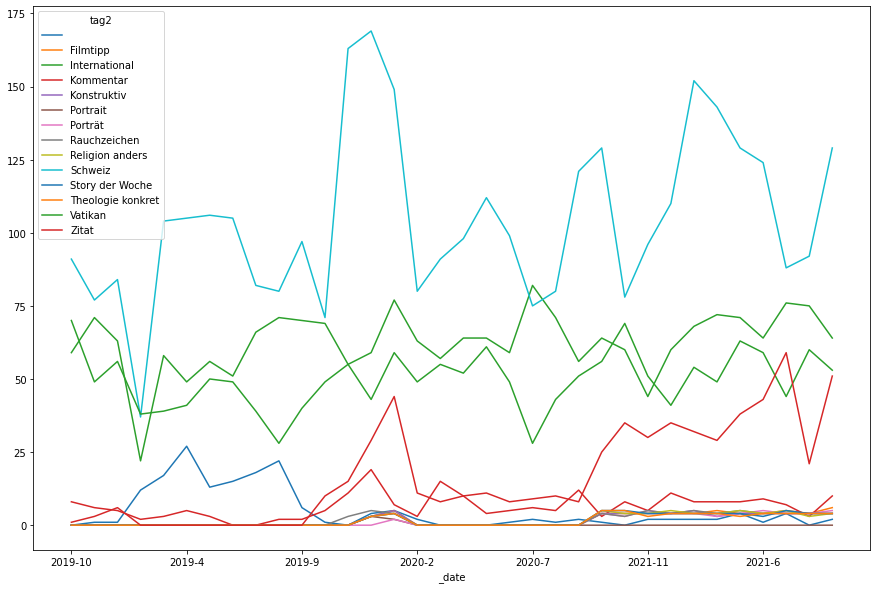

In [19]:
df_data = df.copy()

# Set date
df_data['_date'] = pd.to_datetime(df_data['date'].dt.date)
df_data['_date'] = df_data['_date'].apply(lambda x: "%s-%s" % (x.year, x.month))

gr = pd.pivot_table(df_data, index='_date', columns='tag2', values='title', aggfunc='count')
gr = gr.fillna(0)

# Add Rolling AVG
#gr = gr.apply(lambda col: col.rolling(7).sum(), axis = 0)

gr.plot.line()

## Export everything related to Chur/Domkapitel from November and December

In [20]:
# Wordlist
wordlist = ['chur', 'grichting', 'huonder', 'domkapitel']

df_data = df[(df.date >= '2020-11-01') & (df.date <= '2020-12-31')].copy()

# Set date
df_data['_date'] = df_data['date'].dt.date
df_data['_date'] = pd.to_datetime(df_data['_date'])

# Add Chur
df_data['chur'] = df_data.text.apply(lambda x: any(s.lower() in x.lower() for s in wordlist))

# Select Only Chur
df_data = df_data[df_data.chur]

df_data.to_csv('../export/domkaptelleaks.csv', index=False)

## Analyse Domkapitelleak
https://matplotlib.org/matplotblog/posts/warming-stripes/

In [21]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.colors import ListedColormap

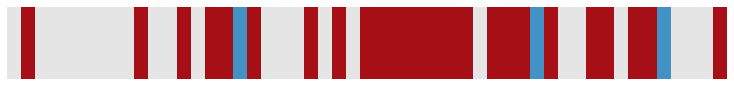

In [22]:
df_chur = pd.read_csv('../export/domkaptelleaks_kategorisiert.csv', sep=';')

# Join with original

df_chur = df_chur[['id', 'kontra']].merge(df, on = 'id', how='left')

df_chur = df_chur.sort_values('date')

#df_chur.set_index('date', inplace=True)
#df_chur.groupby('kontra').count().plot.bar()

cmap = ListedColormap(['#4292c6', '#e5e5e5', '#a50f15'])

fig = plt.figure(figsize=(10, 1))

ax = fig.add_axes([0, 0, 1, 1])
ax.set_axis_off()

# create a collection with a rectangle for each year

col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(0, len(df_chur))
])

# set data, colormap and color limits

col.set_array(df_chur['kontra'])
col.set_cmap(cmap)
#col.set_clim(-1, 1)
ax.add_collection(col)

ax.set_ylim(0, 1)
ax.set_xlim(0, len(df_chur))

fig.savefig('../export/domkapitelleaks.png')

## Occurence of "Chur", etc

<AxesSubplot:xlabel='_date'>

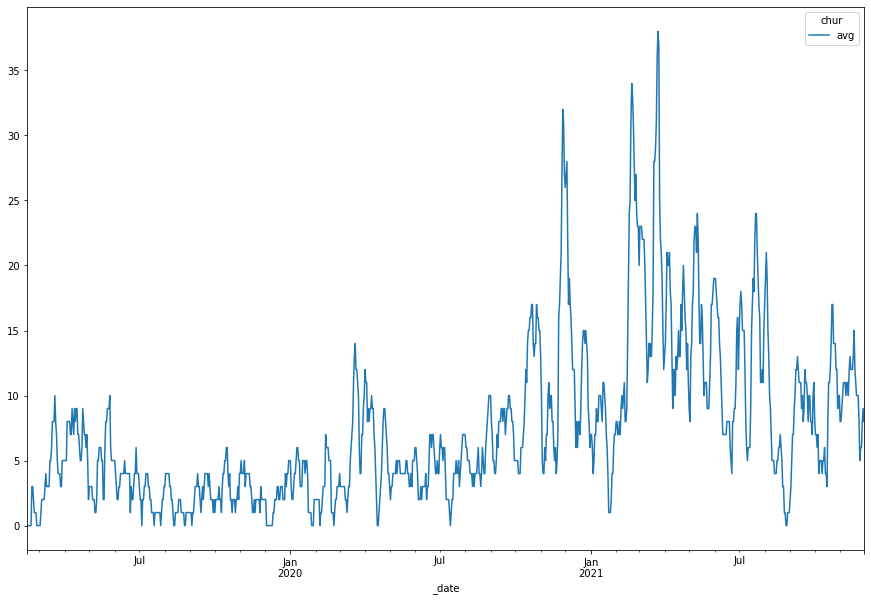

In [23]:
# Wordlist
wordlist = ['chur', 'grichting', 'huonder', 'domkapitel']

df_data = df.copy()

# Set date
df_data['_date'] = df_data['date'].dt.date
df_data['_date'] = pd.to_datetime(df_data['_date'])

# Add Chur
df_data['chur'] = df_data.text.apply(lambda x: any(s.lower() in x.lower() for s in wordlist))

# Select Only Chur
#df_data = df_data[df_data.chur]

# Group by
gr = pd.pivot_table(df_data, index='_date', values='id', columns = 'chur', aggfunc = 'count')

gr[True] = gr[True].fillna(0)

gr = gr.drop(columns=[False])

# Add Rolling AVG
gr['avg'] = gr[True].rolling(7).sum()#apply(lambda x: x.rolling(7).sum())
gr['avg'] = gr['avg'].fillna(0)

#gr.plot()
gr[['avg']].plot()